In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout,Dense
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

from skimage import color

#img = color.rgb2gray(io.imread('image.png'))

In [197]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [198]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')

    plt.show()

Funcion para convertir las imagenes a escala de grises:


```
color.rgb2gray( <image> )
```



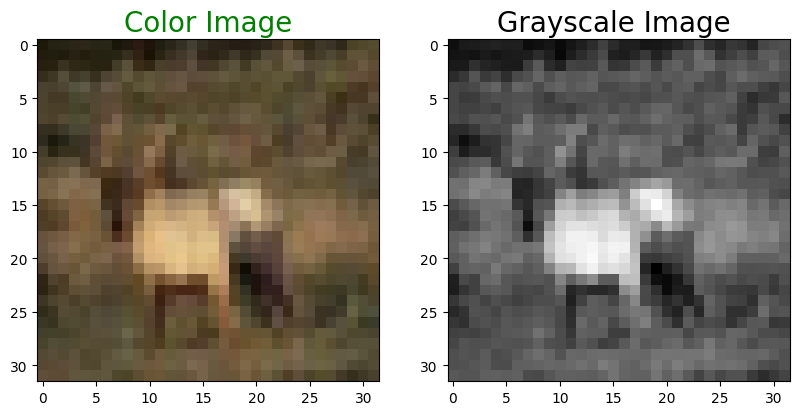

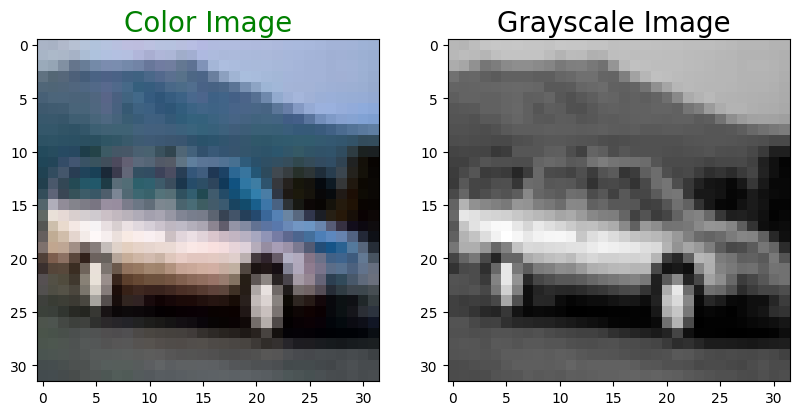

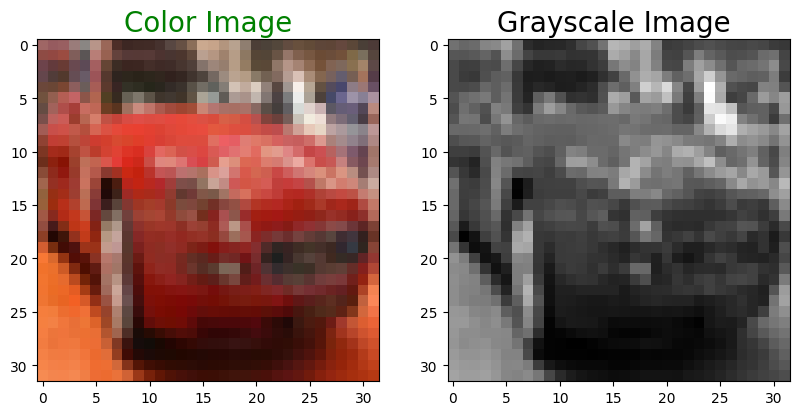

In [199]:
for i in range(3,6):
  plot_images(x_train[i],color.rgb2gray(x_train[i]))

## Enunciado de la práctica 2

Para esta práctica hemos creido necesario que se debe poner en práctica todo lo impartido hasta la fecha, es decir, no solo las arquitecturas impartidad sino tambien las diferentes tipologías de redes mostrada hasta el momento.

Para ello, mediante el dataset anterior queremos implementar un modelo capaz de frente a una entrada de imagenes en blanco y negro, sea capaz de colorearlas. De esta manera se establecen los siguiente puntos:


1.   Implementar la arquitectura mediante redes MLP
2.   Implementar la arquitectura mediante redes Convolucionales
3.   (Opcional) Probar diferentes arquitecturas CNN que puedan mejorar lo resultados.



Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 4096)              4198400   
                                                                 
 dense_186 (Dense)           (None, 1024)              4195328   
                                                                 
 dense_187 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_188 (Dense)           (None, 10)                10250     
                                                                 
Total params: 9453578 (36.06 MB)
Trainable params: 9453578 (36.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
125/125 - 3s - loss: 2.0800 - accuracy: 0.2392 - val_loss: 2.0313 - val_accuracy: 0.2657 - 3s/epoch - 22ms/step
Epoch 2/20
125/12

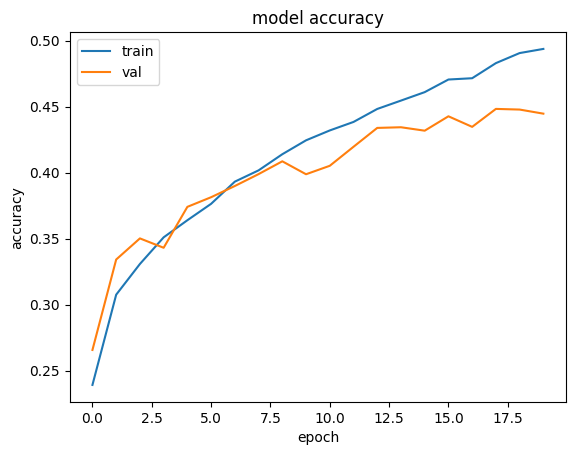

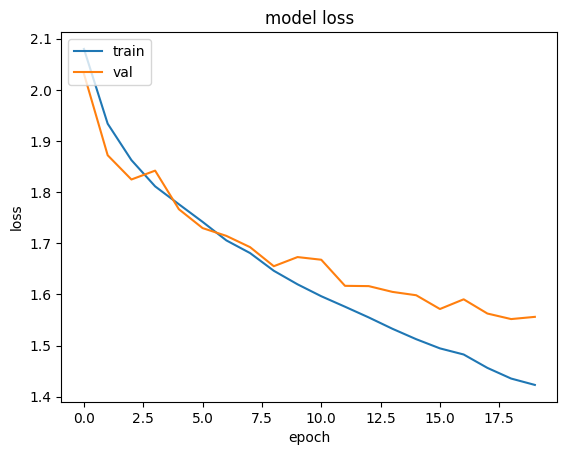

In [200]:
# Aplanar las imágenes en escala de grises
x_train_gray =color.rgb2gray(x_train)
x_test_gray = color.rgb2gray(x_test)
num_pixels = x_train_gray.shape[1] * x_train_gray.shape[2]
x_train_gray = x_train_gray.reshape((x_train_gray.shape[0], num_pixels)).astype('float32')
x_test_gray = x_test_gray.reshape((x_test_gray.shape[0], num_pixels)).astype('float32')

y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Normalizar los valores de píxeles
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

# Definir el modelo MLP
model_mlp = Sequential([
    (Dense(4096, input_shape=(num_pixels,),kernel_initializer='normal', activation='relu')),
    (Dense(1024,  kernel_initializer='normal', activation='relu')),
    (Dense(1024,  kernel_initializer='normal', activation='relu')),
    (Dense(y_test.shape[1], kernel_initializer='normal', activation='softmax'))] )

print(model_mlp.summary())

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Entrenar el modelo
history=model_mlp.fit(x_train_gray, y_train, epochs=20, batch_size=400, validation_data=(x_test_gray, y_test), verbose=2)

scores = model_mlp.evaluate(x_test_gray, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-float(scores[1])*100))

history_dict = history.history
print(history_dict.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_27 (Flatten)        (None, 32768)             0         
                                                                 
 dense_189 (Dense)           (None, 2048)              67110912  
                                                     

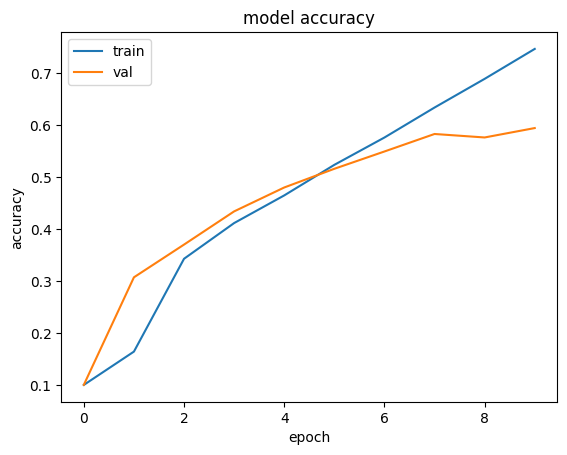

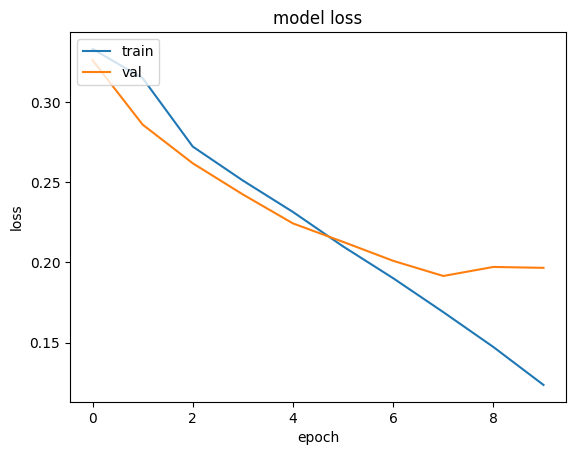

In [201]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


# Reformatear los datos para que sean adecuados para una CNN
x_train_cnn = x_train_gray.reshape((x_train_gray.shape[0], 32, 32, 1)).astype('float32')
x_test_cnn = x_test_gray.reshape((x_test_gray.shape[0], 32, 32, 1)).astype('float32')

# Definir el modelo CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(2048, activation='relu'),
    Dense(512, activation='relu'),
    Dense(y_test.shape[1], activation='sigmoid')
])

print(model_cnn.summary())
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo CNN
history=model_cnn.fit(x_train_cnn, y_train, epochs=10, batch_size=200, validation_data=(x_test_cnn, y_test), verbose=2)

# Evaluar el modelo en el conjunto de prueba
scores_cnn = model_cnn.evaluate(x_test_cnn, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100 - scores_cnn[1] * 100))

history_dict = history.history
print(history_dict.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()